<a href="https://colab.research.google.com/github/Tasfia48/CS584/blob/main/HW4_Mashiat_Tasfia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Team Name: "chi"
* Rank: 418
* RMSE: 0.80

#Goal
My goal for this homework was to build a movie recommender system to predict the 5-star rating a movie will get for a given user. I utilized the idea of model based recommender system to complete the task.

In [ ]:
#Load the necessary python libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
from scipy.sparse.linalg import svds
import re
import sklearn
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Data

In [ ]:
dfTrain = pd.read_csv('train.dat')
dfTest = pd.read_csv('test.dat')

In [ ]:
# Process train and test data
def preprocess(df):
  df['userID'] = df['userID movieID rating'].str.split(' ').str[0]
  df['movieID'] = df['userID movieID rating'].str.split(' ').str[1]
  df['rating'] = df['userID movieID rating'].str.split(' ').str[2]
  df= df[['userID','movieID','rating']]
  df['movieID']=df['movieID'].astype('str')
  df['userID']=df['userID'].astype('str')
  df['rating']=df['rating'].astype('float')
  return df
def preprocess_test(df):
  df['userID'] = df['userID movieID'].str.split(' ').str[0]
  df['movieID'] = df['userID movieID'].str.split(' ').str[1]
  df= df[['userID','movieID']]
  df['movieID']=df['movieID'].astype('str')
  df['userID']=df['userID'].astype('str')
  return df  

In [ ]:
trainData = preprocess(dfTrain)
testData = preprocess_test(dfTest)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
#first five records of training data
trainData.head(5)

,userID,movieID,rating
0,75,3,1.0
1,75,32,4.5
2,75,110,4.0
3,75,163,4.0
4,75,165,4.5


In [ ]:
#first five records of test data
testData.head(5)

,userID,movieID
0,75,653
1,75,1527
2,75,3258
3,75,7007
4,78,82


**Collaborative Filtering (CF)**<br>Collaborative filtering produces recommendations based on the knowledge of users’ preference to items. Users give ratings to catalog items (implicitly or explicitly). Customers who had similar tastes in the past, will have similar
tastes in the future. CF can be divided into Memory-Based Collaborative Filtering and Model-Based Collaborative Filtering.

**Model-Based Collaborative Filtering**<br>
Model-based CF methods are based on matrix factorization (MF). MF methods are used as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization restructures the user-item matrix into a low-rank matrix. This can be represented by the multiplication of two low-rank matrices, where the rows contain a vector of latent variables. This matrix is required to approximate the original matrix, as closely as possible, by multiplying the low-rank matrices together. That way, we can predict the missing entries in the original matrix.




**Singular Value Decomposition**<br>
Collaborative Filtering can be formulated by approximating a matrix X by using Singular Value Decomposition (SVD). SVD can be expressed as:

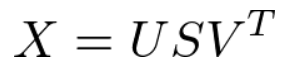

Given m×n matrix X:


1.   U is (m×r) orthogonal matrix
2.   S is (r×r) diagonal matrix with non-negative real numbers on the diagonal
3.   VT is (r×n) orthogonal matrix <br>
where U represents feature vectors of the users, V represents feature vectors of the items and the elements on the diagonal of S are known as singular values.

**Root-Mean-Square Error (RMSE)**<br>
The measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. The RMSE represents the square root of the second sample moment of the differences between predicted values and observed values or the quadratic mean of these differences. <br>
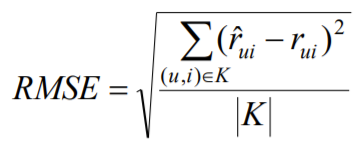

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

### Data Exploration

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


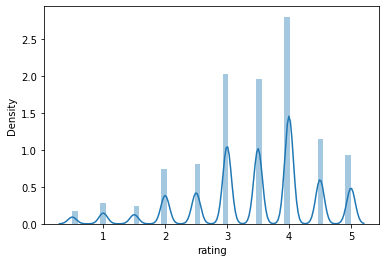

In [ ]:
#Distribution of users rating
sns.distplot(trainData["rating"]);

In [ ]:
# avarge rating 
avarge_rating = trainData['rating'].mean()
print("average rating",avarge_rating)

average rating 3.4386223135769263


### Matrix Factorization (MF) using SVD

For Model based RS approach, initially I implemented the matrix factorization using SVD process. I created a user_item rating matrix. Here Pivot table function is used as we want one to one maping between movies, user and their rating. So by default pivot_table command takes average if we have multiple values of one combination.

In [ ]:
utility_matrix = trainData.pivot_table(values='rating', index='userID', columns='movieID', fill_value=0) # rating matrix
R = utility_matrix.values
user_ratings_mean = np.mean(R, axis = 1) # calculated the mean rating for each user
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1) # normalized the ratings based on the users by subtracting the mean
user_ratings_mean_df = pd.DataFrame(user_ratings_mean,index=utility_matrix.index,columns=['mean']) #dataframe storing the mean rating w.r.t to the user

In [ ]:
#user_movie rating matrix
utility_matrix.head(5)

movieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,1008,1009,101,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,102,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,103,1030,1031,1032,1033,1034,...,956,957,958,959,96,960,961,963,964,965,966,967,968,969,97,970,971,972,973,974,976,98,980,981,982,984,985,986,987,988,99,990,991,992,993,994,996,997,998,999
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10025,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,2.5,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
10058,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
10064,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
10084,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
10094,2.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
n_users = dfTrain.userID.unique().shape[0]
n_movies = dfTrain.movieID.unique().shape[0]
sparsity = round(1.0 - len(dfTrain) / float(n_users * n_movies), 3)
print('The sparsity level of trainnig dataset is '+ str(sparsity * 100) + '%')

The sparsity level of trainnig dataset is 96.89999999999999%


I varied the number of features for decomposition to identify the optimal value. I used the training dataset and calculated RMSE for each round of prediction

In [ ]:
rmse_values = []
K=[]
for i in range(20,60):
  U, sigma, Vt = svds(Ratings_demeaned, k=i) # deomposed rating matrix into user and movie features and diagonal vector
  sigma = np.diag(sigma) # singular values
  predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1) # reconstructing user-movie rating matrix to get the rating for unrated movies.
  preds = pd.DataFrame(predicted_ratings, columns = utility_matrix.columns, index=utility_matrix.index)
  K.append(i)
  rmse_values.append(rmse(utility_matrix.values,preds.values))

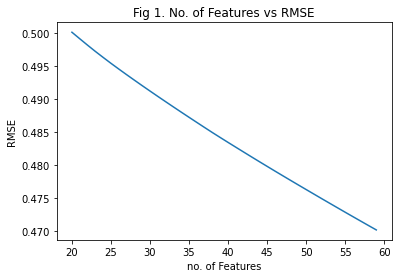

In [ ]:
plt.plot(K, rmse_values)
plt.xlabel("no. of latent leatures")
plt.ylabel("RMSE")
plt.title("Fig 1. no. of latent features vs RMSE")
plt.show()

From fig 1, it can be observed that with the increase of no. of feature the RMSE decreased. But no elbow point is visible. I decided to take 50 features for decompositon and continue rest of the assignment. I will normalize the user_movie rating matrix w.r.t to user_based_rating, then decompose the matrix into user matrix and movie matrix, each with 50 features. Then reconstruct the rating matrix by the dot product of user, movie feature matrices and add the mean for each user rating. This way, we can get the rating for unrated movies for each user.  

In [ ]:
  U, sigma, Vt = svds(Ratings_demeaned, k=50) # deomposed rating matrix into user and movie features and diagonal vector
  sigma = np.diag(sigma) # singular values
  predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1) # reconstructing user-movie rating matrix to get the rating for unrated movies.
  preds = pd.DataFrame(predicted_ratings, columns = utility_matrix.columns, index=utility_matrix.index)

In [ ]:
#Predicted rating matrix
preds.head(5)

movieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,1008,1009,101,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,102,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,103,1030,1031,1032,1033,1034,...,956,957,958,959,96,960,961,963,964,965,966,967,968,969,97,970,971,972,973,974,976,98,980,981,982,984,985,986,987,988,99,990,991,992,993,994,996,997,998,999
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10025,0.955101,-0.182517,-0.000042,0.010267,-0.001901,0.000225,-0.056990,-0.035117,0.039569,0.033344,0.048588,0.110959,0.300591,-0.043706,-0.025842,0.128439,0.100203,0.039122,-0.139618,-0.028385,0.118917,0.048971,-0.290691,0.029537,0.057351,0.059564,0.302286,0.135146,0.048541,0.001360,0.005213,0.050981,0.432718,-0.020308,-0.027778,0.133004,0.106353,-0.079561,0.140255,-0.032037,...,0.033273,0.023131,-0.000100,0.020011,0.043406,0.033095,0.002170,0.032633,-0.059920,-0.039953,-0.003773,-0.005740,0.014774,0.233354,-0.130979,-0.023332,0.175662,0.007496,0.055562,-0.046304,0.033031,-0.022181,0.013759,0.004120,-0.010365,0.018869,0.010435,0.087278,-0.017631,0.002254,-0.056533,-0.021708,0.108583,-0.033462,-0.021741,0.465699,0.011982,-0.030106,-0.008694,-0.076709
10058,0.719140,0.107967,0.088333,-0.011378,-0.003432,0.071231,0.033282,0.000925,0.080406,0.013107,-0.009093,0.046600,0.017719,0.054099,-0.014998,-0.047254,-0.064782,-0.034326,0.064846,-0.011642,0.096990,-0.012573,0.089113,-0.004616,-0.134210,-0.001008,-0.021048,-0.020683,-0.047610,-0.078924,0.001651,0.044911,-0.250584,-0.041025,0.044122,-0.012043,-0.096667,-0.107550,0.055493,-0.001169,...,-0.001495,0.010842,0.002215,0.019224,-0.019290,-0.018106,0.022468,0.025125,0.023102,-0.030213,-0.011873,0.013098,0.020319,0.093572,0.139502,-0.058311,0.061598,0.001705,0.064321,0.025263,0.000549,-0.000050,-0.004864,-0.012338,-0.028271,0.017288,0.000585,0.033696,-0.003333,0.013334,-0.007331,0.004878,-0.001558,0.005981,0.005810,-0.107680,-0.001760,0.007001,0.030118,0.071531
10064,0.017136,-0.022044,0.034979,0.002245,0.008749,0.005307,0.018575,0.011017,0.012559,-0.020164,-0.008712,-0.015180,-0.009504,-0.022378,0.004575,-0.016325,-0.015519,0.016357,-0.011483,-0.021341,0.004106,0.007667,0.004034,0.007014,-0.028682,-0.037051,0.017412,0.019957,0.002209,0.027772,0.000717,0.076634,0.024122,0.029995,0.001204,0.014433,0.019458,0.023199,0.012735,0.005409,...,0.003985,-0.004303,0.003858,-0.012927,-0.001140,-0.006262,-0.009972,-0.008097,0.011097,0.054838,-0.001384,-0.009080,0.004477,0.003583,-0.010151,-0.004509,0.021329,0.003370,-0.019476,0.007509,-0.001143,0.004611,0.004748,-0.000174,0.001609,0.001946,-0.003980,0.045466,-0.019798,0.020506,0.010119,0.011577,0.035788,-0.000643,0.008881,-0.021195,0.023563,-0.012899,0.022032,0.011578
10084,0.685647,0.241647,0.003042,0.031437,0.001400,0.037758,0.008221,-0.071608,0.003109,0.065525,0.007250,0.016671,-0.121771,-0.030901,0.018299,-0.001044,0.029981,0.029911,0.020675,0.059191,-0.094734,0.007520,-0.005465,-0.011850,0.099052,0.050604,0.098812,0.013601,-0.009833,-0.013906,0.002820,0.178844,0.249235,0.130335,0.056373,0.016722,0.051365,0.052949,0.153868,0.075765,...,-0.015962,0.009028,0.021293,-0.014201,-0.006747,0.020795,0.015905,-0.012182,-0.042962,-0.144248,-0.001959,0.016875,0.054962,-0.115026,0.060412,0.025022,-0.035284,-0.007756,0.056344,-0.036153,0.012489,-0.000426,-0.011481,-0.003580,0.023323,0.020694,-0.006738,-0.027802,0.005034,0.002111,-0.007975,0.061316,-0.055325,0.022271,-0.016631,-0.002591,0.168930,-0.022890,0.002095,-0.018698
10094,1.570927,0.421924,0.022504,0.018661,0.030121,-0.001996,-0.041605,0.043333,-0.012648,-0.025311,0.002449,-0.055936,-0.238678,0.128227,0.057559,-0.038427,0.008594,-0.025156,0.020961,0.018819,0.027008,-0.027841,0.096321,-0.016450,0.171526,-0.007544,0.285530,0.194759,0.014207,0.183259,0.009784,0.041345,0.535004,0.309526,-0.030716,-0.004446,-0.068128,0.336764,0.012507,0.071562,...,-0.009763,0.024822,-0.006926,-0.051501,0.007354,-0.020360,-0.009716,0.066674,-0.028010,-0.057732,-0.014882,-0.010441,-0

**Prediction for test dataset**<br>
For the test dataset. I computed the rating for each user, movie pair from the predicted matrix built by SVD.

In [ ]:
ratings = []
err = 0
for index,row in testData.iterrows():
  try:
    rating = preds.loc[row.userID].loc[row.movieID] + user_ratings_mean_df.loc[row.userID]['mean']
    ratings.append(rating)
  except Exception as e:
    ratings.append(avarge_rating)
    err += 1
    continue;
testData['rating'] = ratings
print("Movies not in trainning set", err)
testData.head()

Movies not in trainning set 66


,userID,movieID,rating
0,75,653,0.252761
1,75,1527,1.056054
2,75,3258,0.073782
3,75,7007,0.091500
4,78,82,0.889309


There were 66 movies in the test data which were not present in training dataset. This is defined as the **cold start** problem.I set the rating for these movies to the avarge rating of the data set initial before using the additional information. I submitted the result to miner and the result were very poor. The RMSE was 2.45. As the dataset is quite sparse (96%) and there are missing data for 66 movies. So, SVD is not performing well. <br>

I am going to use Stochastic Gradient Descent (SGD) for minimizing the regularized squared error with respect to a latent user feature matrix and latent movie feature matrix. Similar to SVD, I will use the number of latent factors = 50.

### Matrix Factorization (MF) using SGD
**Stochastic gradient descent**<br>
The approach of predicting ratings by minimizing the regularized squared error with respect to a latent user feature matrix P and a latent item feature matrix Q:<br>
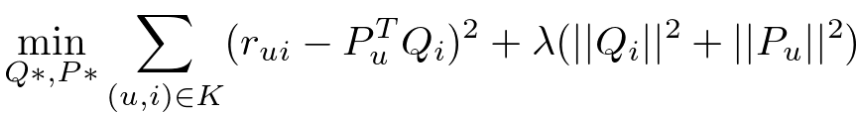<br>
Where K is a set of (u,i) pairs, r(u,i) is the rating for item i by user u and λ is a regularization term (used to avoid overfitting). The training of my model consists of minimizing the regularized squared error. After an estimate of P and Q is obtained, we can predict unknown ratings by taking the dot product of the latent features for users and items.<br>
I will apply Stochastic Gradient Descent (SGD) in order to minimize the loss function.
Stochastic gradient descent (SGD) is an iterative method for optimizing an objective function with suitable smoothness properties. It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient  by an estimate thereof. Especially in high-dimensional optimization problems this reduces the computational burden, achieving faster iterations in trade for a lower convergence rate.

Initially, I created two matrices for the latent features of the users and ratings. For each user, movie pair, I calculated the error (note we use a simple difference of the existing and predicted ratings). Then update P and Q using Gradient Descent.
After each training epoch, I calculate the training and validation errors and store their values to analyze later. Then use the optimum value of P and Q to predict the rating for the unrated movies.<br>
Typical CF data exhibit large user and item effects – i.e., systematic tendencies for some users to give higher ratings than others,and for some items to receive higher ratings than others. It is customary to adjust the data by accounting for these effects, which is encapsulated within the baseline estimates. Denote by μ the overall average rating. Where bu and bi represents respectively the bias for user and item. My goal was to get the optimal value of P and Q to minimize the second equation. <br>
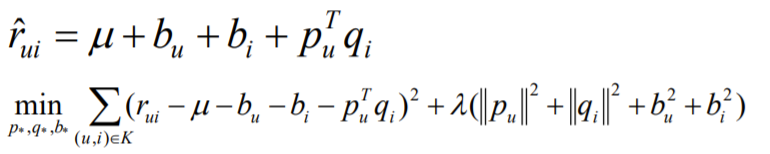

In [ ]:
temp = trainData.copy()
ratings_df = temp.pivot( # user-movie rating matrix
    index='userID',
    columns='movieID',
    values='rating'
)
ratings = ratings_df.fillna(0).values

In [ ]:
# Creating training and validation set from the training data to determine the optimal P and Q.
def train_test_split(ratings):
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= 35: # user who rating more than 35 movies
            val_ratings = np.random.choice(
              ratings[user, :].nonzero()[0],
              size=15, # storing the rating for 15 movies in validation set
              replace=False
            )
            train[user, val_ratings] = 0  # chaning the rating for 15 movies to 0 in training set
            validation[user, val_ratings] = ratings[user, val_ratings] # changed data for users who rated more than 35 movies of their rating for 15 random movies
    return train, validation
train, validation = train_test_split(ratings)    

### SGD implementation

In [ ]:
n_epochs=100 
n_latent_features=50
lmbda=0.1
learning_rate=0.001
m,n = ratings.shape
mu = temp['rating'].mean()

def prediction_single(P, Q, bu, bi):
  return mu+bu+bi+np.dot(P.T, Q)
  
def prediction_full(P, Q, bu, bi):
  return mu+bu[:,np.newaxis]+bi[np.newaxis:,]+np.dot(P.T, Q)

def predict(X_train, user_index):
  y_hat = prediction_full(P, Q, bu, bi)
  predictions_index = np.where(X_train[user_index, :] == 0)[0]
  return y_hat[user_index, predictions_index].flatten()

def fit(X_train, X_val):
  bu = np.random.rand(m) # initial bias for users
  bi = np.random.rand(n) # initial bias for movies
  P = np.random.rand(n_latent_features, m) #initial random feature matrix for user
  Q = np.random.rand(n_latent_features, n) #initial random feature matrix for movies
  train_error = []
  val_error = []
  users, items = X_train.nonzero()
  total_steps = 0
  for epoch in range(n_epochs):
      total_steps += 1
      for u, i in zip(users, items):
          error = X_train[u, i] - prediction_single(P[:,u], Q[:,i], bu[u], bi[i])
          P[:, u] += learning_rate * (error * Q[:, i] - lmbda * P[:, u])
          Q[:, i] += learning_rate * (error * P[:, u] - lmbda * Q[:, i])
          bu[u] += learning_rate * (error - lmbda * bu[u]) #updating bias for each user
          bi[i] += learning_rate * (error - lmbda * bi[i]) # updating bias for each movie
      train_rmse = rmse(prediction_full(P, Q, bu, bi), X_train) #calculating error for training set
      val_rmse = rmse(prediction_full(P, Q, bu, bi), X_val) # calculating error for validation set
      train_error.append(train_rmse)
      val_error.append(val_rmse)
      if not epoch%10:
        print(epoch)
      if epoch > 0:
        improv1 = abs(train_error[-1] - train_error[-2])
        improv2 = abs(val_error[-1] - val_error[-2])
        if(improv1 < 0.0001 and improv2 < 0.0001): ## if errors is less then 0.0001 for both training and validation converged
          print("converged!!")
          break;      
  return {'epoch':total_steps,'train_error':train_error,'val_error':val_error, 'P':P, 'Q':Q, 'bu': bu, 'bi':bi}
  


### Cross Validation (3-fold)

In [ ]:
all_results = {}
for k in range(3): 
  print("running "+ str(k)+ " fold")
  train, validation = train_test_split(ratings)
  all_results[k] = fit(train, validation)
   

running 0 fold
0
10
20
30
40
50
60
70
80
90
running 1 fold
0
10
20
30
40
50
60
70
80
90
running 2 fold
0
10
20
30
40
50
60
70
80
90


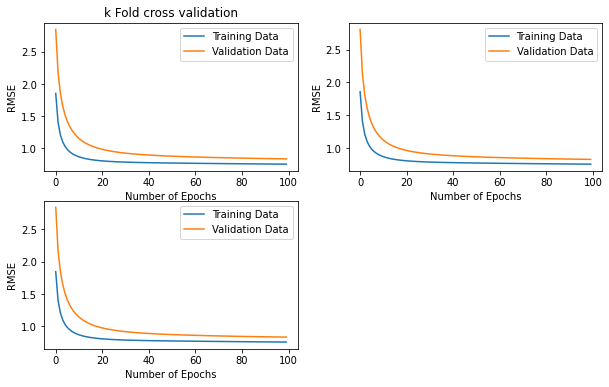

In [ ]:

### Ploting the rmse error for training data and valiadation data
fig,ax = plt.subplots(2,2,figsize=(10,6)) 
ax[0][0].plot(range(all_results[0]['epoch']), all_results[0]['train_error'], label='Training Data');
ax[0][0].plot(range(all_results[0]['epoch']), all_results[0]['val_error'],label='Validation Data');
ax[0][0].set_xlabel('Number of Epochs');
ax[0][0].set_ylabel('RMSE');
ax[0][0].set_title("k Fold cross validation")
ax[0][0].legend()

ax[0][1].plot(range(all_results[1]['epoch']), all_results[1]['train_error'], label='Training Data');
ax[0][1].plot(range(all_results[1]['epoch']), all_results[1]['val_error'],label='Validation Data');
ax[0][1].set_xlabel('Number of Epochs');
ax[0][1].set_ylabel('RMSE');
# ax[0][1].set_title("k Fold cross validation")
ax[0][1].legend()

ax[1][0].plot(range(all_results[2]['epoch']), all_results[2]['train_error'], label='Training Data');
ax[1][0].plot(range(all_results[2]['epoch']), all_results[2]['val_error'],label='Validation Data');
ax[1][0].set_xlabel('Number of Epochs');
ax[1][0].set_ylabel('RMSE');
# ax[1][0].set_title("k Fold cross validation")
ax[1][0].legend()

ax[-1, -1].axis('off')
plt.show()

### 

In [ ]:
movies = ratings_df.columns
users =  ratings_df.index
def create_dictonary (index,ratings):
  data ={str(index[i]): ratings[i] for i in range(len(index))}
  return data  

In [ ]:
### Storing existing rating for movies by each user for faster computation
existing = {} 
for user in users:
    existing[user] = {} 
    user_index = ratings_df.index.get_loc(user)
    existing_ratings_index = np.where(ratings[user_index, :] > 0)[0]
    existing_ratings = ratings[user_index, existing_ratings_index]
    existing[user] = create_dictonary(existing_ratings_index,existing_ratings)

In [ ]:
###creating prediction dictionary for unrated movie by each user for faster computation
predicted = {}  
for user in users:
    predicted[user] = {} 
    user_index = ratings_df.index.get_loc(user)
    predictions_index = np.where(ratings[user_index, :] == 0)[0]
    rating_predictions = predict(ratings, user_index)
    predicted[user] = create_dictonary(predictions_index,rating_predictions)

**Prediction for Test set**<br>Initially for the cold start movies I assigned the rating to the averge rating and for other movie ratings, I collected the rating from my prediction dictionary for each user and movie pair.


In [ ]:
testDataSGD = preprocess_test(dfTest)
rate = []
err = 0
unlisted_movies=[]
for index,row in testDataSGD.iterrows():
  if row.movieID in movies:
    if row.userID in users:
      # print(row.userID)
      col_index = str(ratings_df.columns.get_loc(row.movieID))
      user_id = row.userID
      user_index = ratings_df.index.get_loc(user_id)
      if str(col_index) in list(existing[user_id].keys()):
        # print("existing rating",existing[user_id][col_index])
        rate.append(existing[user_id][col_index])
      elif str(col_index) in list(predicted[user_id].keys()):
        # print("predicted rating",user_id,predicted[user_id][col_index])
        rate.append(predicted[user_id][col_index]) 
      else:
        rate.append(avarge_rating)   
  else:
    rate.append(avarge_rating)
    unlisted_movies.append(row.movieID)
    err += 1    
testDataSGD['rating'] = rate
print("Movies not present in Traning set", err)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Movies not present in Traning set 66


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#predicted rating for test data using SGD
testDataSGD.head(5)

,userID,movieID,rating
0,75,653,3.293538
1,75,1527,3.658139
2,75,3258,3.516875
3,75,7007,4.484604
4,78,82,4.238441


In [ ]:
#converting less than 0 rating to 0 and greater than 5 rating to 5
a =  testDataSGD['rating'].values 
b=[]
for i in a:
  if (i>5):
    b.append(5)
  elif (i<0):
    b.append(0)
  else:
    b.append(i)   

In [ ]:
#Storing results for the test data in format.txt
with open('format.txt', 'w') as filehandle:
    for listitem in b:
        filehandle.write('%s\n' % listitem)

**Using Additional information for rating Cold start movies**

---
I used the movie genre information to get the similar movies and assigned the rating for unlisted movie to the rating of the most similar movie rated by that particular user. 



In [ ]:
def preprocess_genre(df):
  df['movieID'] = df['movieID\tgenre'].str.split('\t').str[0]
  df['genre'] = df['movieID\tgenre'].str.split('\t').str[1]
  df= df[['movieID','genre']]
  df['movieID']=df['movieID'].astype('str')
  df['genre']=df['genre'].astype('str')
  return df

In [ ]:
dfgenre = pd.read_csv('movie_genres.dat')
genre = preprocess_genre(dfgenre)
genre = genre.astype(str)
keys = genre.movieID.unique()
genreDict = dict(zip(keys, ([] for _ in keys)))
for index,row in genre.iterrows():
  if row.movieID in genre.movieID.unique():
    genreDict[row.movieID].append(row.genre)
for k in genreDict.keys():
  genreDict[k] = ' '.join(genreDict[k])    # storing the genres of each movie in a dictionary, key = movieID, value= genres as string 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
unlistedDict = dict(zip(unlisted_movies, ([] for _ in unlisted_movies)))
for j in unlisted_movies:
  if j in genreDict.keys():
    unlistedDict[j].append(genreDict[j]) # storing the genres of unlisted movies only in a dictionary, key = movieID, value= genres 
    del genreDict[j] #delecting records of unlisted movies from original dictionary

In [ ]:
#Coverting the two listed and unlisted dictionary into pandas dataframe
dataGenre= pd.DataFrame.from_dict(genreDict, orient='index',columns=['genre']).reset_index()
dataGenre= dataGenre.rename(columns= {"index" : "movieID"})
dataUnlisted= pd.DataFrame.from_dict(unlistedDict, orient='index',columns=['genre'])

In [ ]:
#listed
dataGenre.head(2)

,movieID,genre
0,1,Adventure Animation Children Comedy Fantasy
1,2,Adventure Children Fantasy


In [ ]:
#unlisted
dataUnlisted.head(2)

,genre
1915,Drama
1434,Action


I used TF-IDF Sklearn Python to calculate the tf-idf score. I used TfidfVectorizer class for calualting TF-IDF for each word genre strings for listed and unlisted movies.  Later, I calculated the cosine similarity between them and stored the movieID of the most similar genre w.r.t to unlisted movies

In [ ]:
tf1 = TfidfVectorizer()
tf =tf1.fit(dataGenre['genre'])
listed =tf.transform(dataGenre['genre']) #Transforming gernes to genre-term matrix
unlisted =tf.transform(dataUnlisted['genre']) #Transforming gernes to genre-term matrix
sim_sparse = cosine_similarity( unlisted, listed, dense_output=False) # calculating cosine similarity for each entry of unlisted set with all entries of listed set
sim = sim_sparse.toarray()

In [ ]:
ind=[]
for j in range(0,65):
  k = np.argmax(sim[j])
  # print(max(sim[j]), np.unravel_index(np.argmax(sim[j], axis=None), sim[j].shape))
  ind.append(k)
similar=[]
for k in ind:
  similar.append(dataGenre['movieID'].iloc[k])  

In [ ]:
dataUnlisted['similar']=similar
# unlisted movies with the most similar genre movie
dataUnlisted.head(5)

,genre,similar
1915,Drama,14
1434,Action,9
56744,Crime Drama Mystery,159
65091,Crime Drama Romance,81
31011,Documentary,77


In [ ]:
testDataGenre = preprocess_test(dfTest)
rate = []
err = 0
unlisted_movies=[]
for index,row in testDataGenre.iterrows():
  if row.movieID not in movies:
    movieID = dataUnlisted['similar'].loc[row.movieID]
    err += 1 
  else:
    movieID=row.movieID 
  if row.userID in users:
    col_index = str(ratings_df.columns.get_loc(movieID))
    user_id = row.userID
    user_index = ratings_df.index.get_loc(user_id)
    if str(col_index) in list(existing[user_id].keys()):
      rate.append(existing[user_id][col_index])
    elif str(col_index) in list(predicted[user_id].keys()):
      rate.append(predicted[user_id][col_index]) 
    else:
      rate.append(avarge_rating)      
testDataGenre['rating'] = rate
print("Movies not present in Traning set", err)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Movies not present in Traning set 66


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
testDataGenre.head(5)

,userID,movieID,rating
0,75,653,3.293538
1,75,1527,3.658139
2,75,3258,3.516875
3,75,7007,4.484604
4,78,82,4.238441


In [ ]:
#converting less than 0 rating to 0 and greater than 5 rating to 5
c =  testDataGenre['rating'].values 
d=[]
for i in c:
  if (i>5):
    d.append(5)
  elif (i<0):
    d.append(0)
  else:
    d.append(i) 

In [ ]:
#Storing results for the test data in format.txt
with open('formatgenre.txt', 'w') as filehandle:
    for listitem in d:
        filehandle.write('%s\n' % listitem)

I submitted both (SGD with and wothout genre information) of the predicted rating for the test data set in Miner and the RMSE value was 0.80.